# NLP Pipeline for Customer Feedback Analysis on Databricks



--------------------------------------

### 1: Install libraries

In [0]:
%pip install spacy textblob wordcloud
!python -m textblob.download_corpora



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/16.4 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 110.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
databricks-connect 15.4.5 requires numpy<2,>=1.15, but you have numpy 2.2.5 which is incompatible.
scipy 1.11.1 requires numpy<1.28.0,>=1.21.6, but you have numpy 2.2.5 which is incompatible.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
/databricks/python/lib/python3.11/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 2.2.5)
  warnings.warn(f"A NumPy

In [0]:
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 138.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [0]:
dbutils.library.restartPython()

In [0]:
# %pip install numpy==1.26.4
dbutils.library.restartPython()


In [0]:
dbutils.library.restartPython()

--------------------------------

### 2: Import libraries

In [0]:
# Step 
import spacy
from textblob import TextBlob
from wordcloud import WordCloud
from pyspark.sql.functions import udf, col
from pyspark.sql.types import FloatType, ArrayType, StringType
import matplotlib.pyplot as plt

___________________

### 3: Load SpaCy model

In [0]:

nlp = spacy.load("en_core_web_sm")

__________________________

### 4: Load dataset

In [0]:
file_path = "dbfs:/Volumes/workspace/default/test/redmi6.csv"
df = spark.read.option("header", "true").csv(file_path)


____________________________

### 5: Rename columns to safe identifiers

In [0]:

df = df.withColumnRenamed("Review Title", "review_title") \
       .withColumnRenamed("Customer name", "customer_name") \
       .withColumnRenamed("Rating", "rating") \
       .withColumnRenamed("Date", "review_date") \
       .withColumnRenamed("Category", "category") \
       .withColumnRenamed("Comments", "comments") \
       .withColumnRenamed("Useful", "useful")



__________________________

### 6: Sentiment analysis on 'comments'

In [0]:

@udf(FloatType())
def get_sentiment(text):
    if text:
        return TextBlob(text).sentiment.polarity
    return None

df = df.withColumn("sentiment_score", get_sentiment(col("comments")))



-------------------------------

### 7: Named Entity Recognition on 'comments'

In [0]:
@udf(ArrayType(StringType()))
def extract_entities(text):
    if text:
        doc = nlp(text)
        return [ent.text for ent in doc.ents]
    return []

df = df.withColumn("named_entities", extract_entities(col("comments")))


___________________________________

### 8: Display enriched data

In [0]:
df.select(
    "review_title",
    "customer_name",
    "rating",
    "sentiment_score",
    "named_entities",
    "comments"
).show(truncate=False)


+-------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------+---------------+--------------------+------------------------------------------------------------------------------------------+
|review_title                                                                                                             |customer_name                                                                                                            |rating                                                                                    |sentiment_score|named_entities      |comments                                                                                  |
+---------------------------------------------------------------------

___________________________

### 9: WordCloud for key themes

In [0]:
from pyspark.sql.functions import collect_list

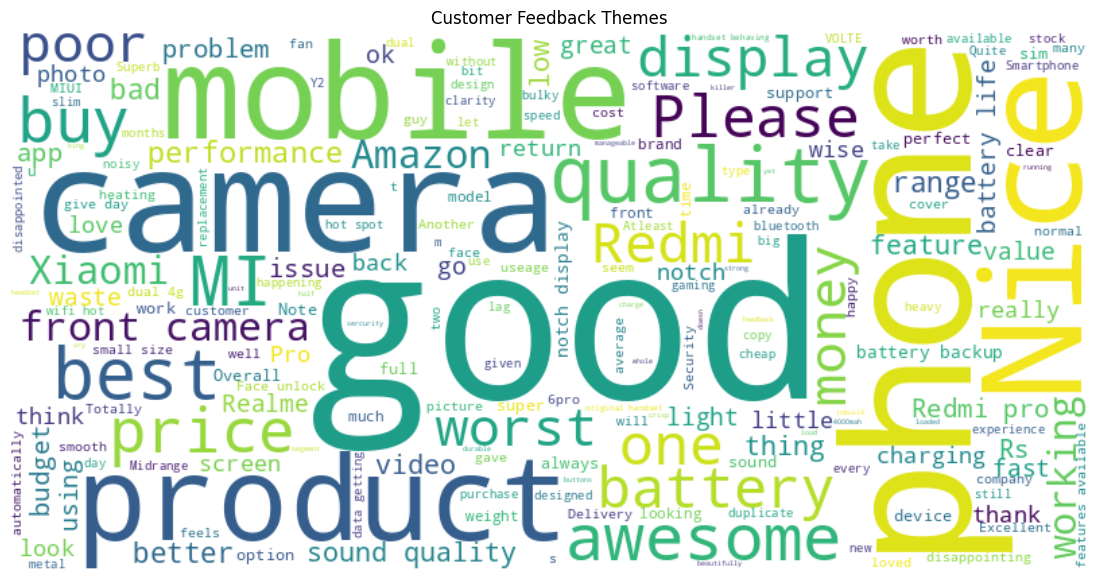

In [0]:

# Collect all non-null comments into a single string
combined_text = " ".join(
    df.select("comments")
      .where(col("comments").isNotNull())
      .agg(collect_list("comments"))
      .first()[0]
)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# Plot the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Customer Feedback Themes")
plt.show()